<a href="https://colab.research.google.com/github/kconstable/market_predictions/blob/main/predict_market_prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predict Market Prices

## Import Libraries

In [ ]:
import sys
!{sys.executable} -m pip install fbprophet
from fbprophet import Prophet

In [1]:
import pandas as pd
import numpy as np
import requests
import time
import pickle
import re
import datetime
from datetime import timedelta
from tabulate import tabulate
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller


# alphavalue key
with open('/content/drive/MyDrive/Colab Notebooks/data/av_key.txt') as f:
    key = f.read().strip()

Mounted at /content/drive


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



## Functions

In [310]:
def get_economic_indicators(funct,key,interval=None,maturity=None,throttle=0):
  """
  Returns Economic Indicator Data with missing values interpolated between dates
  Monthly Data:
    NONFARM_PAYROLL, INFLATION_EXPECTATION,CONSUMER_SENTIMENT,UNEMPLOYMENT
  Daily, Weekly, Monthly Data:  
    FEDERAL_FUNDS_RATE = interval (daily,weekly,monthly)
    TREASURY_YIELD = interval (daily, weekly, monthly), 
                     maturity (3month, 5year, 10year, and 30year)
  """
  
  # query strings
  # Monthly Data:
  if funct in ['NONFARM_PAYROLL','INFLATION_EXPECTATION','CONSUMER_SENTIMENT','UNEMPLOYMENT']:
    url = f'https://www.alphavantage.co/query?function={funct}&apikey={key}'

  # Daily, Weekly or Monthly Data:
  # Interest Rates
  if funct == 'FEDERAL_FUNDS_RATE':
    url = f'https://www.alphavantage.co/query?function={funct}&interval={interval}&apikey={key}'

  # Treasury Yield  
  if funct == 'TREASURY_YIELD':
    url = f'https://www.alphavantage.co/query?function={funct}&interval={interval}&maturity={maturity}&apikey={key}'

  # pull data
  r = requests.get(url)
  time.sleep(throttle)
  d = r.json()

  # convert to df
  df = pd.DataFrame(d['data'])

  # move date to a datetime index
  df.date = pd.to_datetime(df.date)
  df.set_index('date',inplace=True)

  # add the ticker name and frequency
  df['name'] = d['name']
  df['interval']=d['interval'] 

  # clean data & interpolate missing values
  # missing data encoded with '.'
  # change datatype to float
  df.replace('.',np.nan,inplace=True)
  df.value = df.value.astype('float')

  # missing data stats
  missing =sum(df.value.isna())
  total =df.shape[0]
  missing_pct = round(missing/total*100,2)

  # interpolate using the time index
  if missing >0:
    df.value.interpolate(method='time',inplace=True)
    action = 'interpolate'
  else:
    action = 'none'

  # Print the results
  if maturity is not None:
    summary = ['Economic Indicator',funct+':'+maturity,str(total),str(missing),str(missing_pct)+'%',action]
  else:
    summary = ['Economic Indicator',funct,str(total),str(missing),str(missing_pct)+'%',action]


  return {'summary':summary,'data':df}

In [311]:
def get_technical_indicators(symbol,funct,key,interval,time_period=None,throttle=0):
  """
  Returns Technical Indicators (only works for stocks, not cyrpto)
  MACD:   symbol,interval
  RSI:    symbol,interval,time_period
  BBANDS: symbol,interval,time_period

  Parameters:
          interval: (1min, 5min, 15min, 30min, 60min, daily, weekly, monthly)
          series_type: (open, close,high,low)-default to close
          timer_periods: Integer
  """
  # build the query string
  if funct =='MACD':
    url = f'https://www.alphavantage.co/query?function={funct}&symbol={symbol}&interval={interval}&series_type=close&apikey={key}'
  if funct in ['RSI','BBANDS']:
    url = f'https://www.alphavantage.co/query?function={funct}&symbol={symbol}&interval={interval}&series_type=close&time_period={time_period}&apikey={key}'

  # request data as json, convert to dict, pause request to avoid the data throttle
  r = requests.get(url)
  time.sleep(throttle)
  d = r.json()

  # extract to a df, add the indicator name, convert the index to datetime
  df = pd.DataFrame(d[f'Technical Analysis: {funct}']).T
  df.index = pd.to_datetime(df.index)

  # convert the data to float
  for col in df.columns:
    df[col] = df[col].astype('float')

  # check for missing data
  missing = df.isnull().any().sum()
  total = len(df)
  missing_pct = round(missing/total*100,2)


  # Print the results
  summary=['Technical Indicator',funct,str(total),str(missing),str(missing_pct)+'%','none']

  return {'summary':summary,'data':df}

In [312]:
def get_crypto_data(symbol,key):
  """
  Pulls daily crypto prices from alpha advantage.
  Inputs:
    symbol: ETH, BTC, DOGE
    key:    The alpha advantage API key
  Output:
    a dataframe of crypto prices: open,high,low, close, volume
  """
  # build query string, get data as json and convert to a dict
  url = f'https://www.alphavantage.co/query?function=DIGITAL_CURRENCY_DAILY&symbol={symbol}&market=CAD&apikey={key}'
  r = requests.get(url)
  d = r.json()

  # extract data to df
  df=pd.DataFrame(d['Time Series (Digital Currency Daily)']).T

  # remove columns not required
  # returns the price in two currencies, just keep USD
  cols = [c for c in df.columns if '(CAD)' not in c]
  df=df.loc[:, cols]
  df.columns = ['open','high','low','close','volume','marketcap']
  df.drop(['marketcap'],axis=1,inplace=True)

  # change data types
  df.index = pd.to_datetime(df.index)

  # convert datatype to float
  for col in ['open','high','low','close','volume']:
    df[col] = df[col].astype('float')

  # add the cyrpto name
  df['symbol'] = d['Meta Data']['3. Digital Currency Name']

  return df

In [313]:
def calc_bollinger(df,feature,window=20,st=2):
  """
  Calculates bollinger bands for a price time-series.  Used for crypto currencies
  Input: 
    df     : A dataframe of time-series prices
    feature: The name of the feature in the df to calculate the bands for
    window : The size of the rolling window.  Defaults to 20 days with is standard
    st     : The number of standard deviations to use in the calculation. 2 is standard 
  Output: 
    Returns the df with the bollinger band columns added
  """

  # rolling mean and stdev
  rolling_m  = df[feature].rolling(window).mean()
  rolling_st = df[feature].rolling(window).std()

  # add the upper/lower and middle bollinger bands
  df['b-upper']  = rolling_m + (rolling_st * st)
  df['b-middle'] = rolling_m 
  df['b-lower']  = rolling_m - (rolling_st * st)

In [314]:
def calc_rsi(df,feature='close',window=14):
  """
  Calculates the RSI for the input feature
  Input:
    df      : A dataframe with a time-series of prices
    feature : The name of the feature in the df to calculate the bands for
    window  : The size of the rolling window.  Defaults to 14 days which is standard
  Output: 
    Returns the df with the rsi band column added
  """
  # RSI
  # calc the diff in daily prices, exclude nan
  diff =df[feature].diff()
  diff.dropna(how='any',inplace=True)

  # separate positive and negitive changes
  pos_m, neg_m = diff.copy(),diff.copy()
  pos_m[pos_m<0]=0
  neg_m[neg_m>0]=0

  # positive/negative rolling means
  prm = pos_m.rolling(window).mean()
  nrm = neg_m.abs().rolling(window).mean()

  # calc the rsi and add to the df
  ratio = prm /nrm
  rsi = 100.0 - (100.0 / (1.0 + ratio))
  df['rsi']=rsi

In [315]:
def calc_macd(df,feature='close'):
  """
  Calculates the MACD and signial for the input feature
  Input:
    df      : A dataframe with a time-series of prices
    feature : The name of the feature in the df to calculate the bands for
  Output: 
    Returns the df with the macd columns added
  """
  ema12 = df[feature].ewm(span=12,adjust=False).mean()
  ema26 = df[feature].ewm(span=26,adjust=False).mean()
  df['macd']=ema12-ema26
  df['macd_signal'] = df['macd'].ewm(span=9,adjust=False).mean()

In [316]:
def get_ticker_data(symbol,key,outputsize='compact',throttle=0):
  """
  Returns daily data for a stock (symbol)
    outputsize: compact(last 100) or full (20 years)
    key: apikey
    symbols: OILK (oil ETF),BAR(gold ETF),VXZ (volatility ETF)
  """
  url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={symbol}&outputsize={outputsize}&apikey={key}'
  r = requests.get(url)
  time.sleep(throttle)
  d = r.json()

  # extract data to a df
  df = pd.DataFrame(d['Time Series (Daily)']).T
  df.columns = ['open','high','low','close','volume']
  df['symbol'] = d['Meta Data']['2. Symbol']

  # change data types
  df.index = pd.to_datetime(df.index)

  # convert datatype to float
  for col in ['open','high','low','close','volume']:
    df[col] = df[col].astype('float')

  # Calculate missing data
  missing = sum(df.close.isna())
  total = df.shape[0]
  missing_pct = round(missing/total*100,2)

  # Print the results
  summary = ['Ticker',symbol,str(total),str(missing),str(missing_pct)+'%','none']

  return {'summary':summary,'data':df}

In [317]:
def get_consolidated_stock_data(symbol,key,config,outputsize='compact',throttle=30,dropna=True):
  """
  Pulls data from alpha advantage and consolidates
  API Limitations: 5 API requests per minute and 500 requests per day
  Inputs:
    symbol: stock ticker
    key   : api key
    config: dictionary which lists the economic, technical and commodities to pull
    outputsize: compact(latest 100) or full (up to 20 years of daily data)
    throttle: number of seconds to wait between api requests
    dropna: True/False, drops any records with nan
  Output:
    A dataframe with consolidated price data for the symbol + economic/technical
    indicators and commodity prices
  """

  # Result header and accumulator
  header = ['Type','Data','Total','Missing',' % ','Action']
  summary =[]

  # Get stock prices
  try:
    results  = get_ticker_data(symbol,key,outputsize,0)
    dff = results['data']
    summary.append(results['summary'])
    print(f'Complete:===>Ticker:{symbol}')
  except:
    print(f'Error:===>Ticker:{symbol}')



  # Get Commodity prices
  # ****************************************************************************
  for commodity in config['Commodities']:
    try:
      # get prices
      results = get_ticker_data(commodity,key,outputsize,throttle)
      df = results['data']
      summary.append(results['summary'])
      print(f'Complete:===>Commodity:{commodity}')


      # rename close to commodity name, remove unneeded columns and join with 
      # the stock prices by date
      df.rename(columns={'close':commodity},inplace=True)
      df.drop(['open','high','low','volume','symbol'],axis=1,inplace=True)
      dff = dff.join(df,how='left')
    except:
      print(f"Error===>Commodity:{commodity}")


  # Economic Indicators
  # ****************************************************************************
  # loop through the config to pull the requested data
  for indicator,values in config['Economic'].items():
    if indicator == 'TREASURY_YIELD':
      for tr in values:
        try:
          results = get_economic_indicators(indicator,key,interval=tr['interval'],maturity=tr['maturity'],throttle=throttle)
          summary.append(results['summary'])
          print(f"Complete:===>{indicator}:{tr['maturity']}")

          df = results['data']
          dff = dff.join(df,how='left')
          dff.rename(columns={"value": tr['name']},inplace=True)
          dff.drop(['name', 'interval'], axis=1,inplace = True)
        except:
          print(f"Error===>{indicator}:{tr['maturity']}")
   
    else: 
      # daily
      if values['interval']=='daily':
        try:
          results = get_economic_indicators(indicator,key,interval=values['interval'],throttle=throttle)
          df = results['data']
          summary.append(results['summary'])
          print(f"Complete:===>{indicator}")

          dff = dff.join(df,how='left')
          dff.rename(columns={"value": values['name']},inplace=True)
          dff.drop(['name', 'interval'], axis=1,inplace = True)
        except:
          print(f"Error===>{indicator}")
  
      else: 
        try:
          # monthly or weekly
          results = get_economic_indicators(indicator,key,throttle=throttle)
          summary.append(results['summary'])
          df = results['data']
          print(f"Complete:===>{indicator}")

          # reindex to daily, fill missing values forward
          days = pd.date_range(start = min(df.index),end =max(df.index),freq='D')
          df =df.reindex(days,method = 'ffill')
      
          # join with the other data
          dff = dff.join(df,how='left')
          dff.rename(columns={"value": values['name']},inplace=True)
          dff.drop(['name', 'interval'], axis=1,inplace = True)
        except:
          print(f"Error===>{indicator}")

  # # Technical Indicators
  # ****************************************************************************
  for indicator,values in config['Technical'].items():
    try:
      results = get_technical_indicators(symbol,indicator,key,values['interval'],values['time_period'],throttle)
      df = results['data']
      summary.append(results['summary'])

      dff = dff.join(df,how='left')
      print(f"Complete:===>{indicator}")
    except:
      print(f"Error===>{indicator}")

  
  # clean column names
  dff.rename(columns={"Real Upper Band":'b-upper',
                      "Real Lower Band":'b-lower',
                      "Real Middle Band":"b-middle",
                      "RSI":"rsi",
                      "MACD_Hist":"macd_hist",
                      "MACD_Signal":"macd_signal",
                      "MACD":"macd"
                      },inplace=True)
      

  # Fill in any missing data after joining all datasets
  dff.fillna(method='bfill',inplace=True,axis = 0)

  # drop rows with missing commodity prices
  if dropna:
    dff.dropna(how='any',inplace=True)

  # print the results table
  print("\n\n")
  print(tabulate(summary,header))

  return dff

In [318]:
def get_consolidated_crypto_data(symbol,key,config,boll_window=20,boll_std=2,rsi_window=14,throttle=30,dropna=True):
  """
  Pulls data from alpha advantage and consolidates
  API Limitations: 5 API requests per minute and 500 requests per day
  Inputs:
    symbol: crypto ticker
    key   : api key
    config: dictionary which lists the economic indicators and commodities to pull
    throttle: number of seconds to wait between api requests
    dropna: True/False, drops any records with nan
  Output:
    A dataframe with consolidated price data for the symbol + economic/technical
    indicators and commodity prices
  """

  # Result header and accumulator
  header = ['Type','Data','Total','Missing',' % ','Action']
  summary =[]

  # Get crypto prices
  try:
    dff  = get_crypto_data(symbol,key)
    
    # add month feature
    dff['month'] = dff.index.month

    print(f'Complete:===>Crypto:{symbol}')

  except:
    print(f'Error:===>Crypto:{symbol}')


  # Get Commodity prices
  # ****************************************************************************
  for commodity in config['Commodities']:
    try:
      # get prices
      results = get_ticker_data(commodity,key,'full',throttle)
      df = results['data']
      summary.append(results['summary'])
      print(f'Complete:===>Commodity:{commodity}')


      # rename close to commodity name, remove unneeded columns and join with 
      # the stock prices by date
      df.rename(columns={'close':commodity},inplace=True)
      df.drop(['open','high','low','volume','symbol'],axis=1,inplace=True)
      dff = dff.join(df,how='left')
    except:
      print(f"Error===>Commodity:{commodity}")


  # Economic Indicators
  # ****************************************************************************
  # loop through the config to pull the requested data
  for indicator,values in config['Economic'].items():
    if indicator == 'TREASURY_YIELD':
      for tr in values:
        try:
          results = get_economic_indicators(indicator,key,interval=tr['interval'],maturity=tr['maturity'],throttle=throttle)
          summary.append(results['summary'])
          print(f"Complete:===>{indicator}:{tr['maturity']}")

          df = results['data']
          dff = dff.join(df,how='left')
          dff.rename(columns={"value": tr['name']},inplace=True)
          dff.drop(['name', 'interval'], axis=1,inplace = True)
        except:
          print(f"Error===>{indicator}:{tr['maturity']}")
   
    else: 
      # daily
      if values['interval']=='daily':
        try:
      
          results = get_economic_indicators(indicator,key,interval=values['interval'],throttle=throttle)
          df = results['data']
          summary.append(results['summary'])
          print(f"Complete:===>{indicator}")

          dff = dff.join(df,how='left')
          dff.rename(columns={"value": values['name']},inplace=True)
          dff.drop(['name', 'interval'], axis=1,inplace = True)
        except:
          print(f"Error===>{indicator}")
  
      else: 
        try:
          # monthly or weekly
         
          results = get_economic_indicators(indicator,key,throttle=throttle)
          summary.append(results['summary'])
          df = results['data']
          print(f"Complete:===>{indicator}")

          # reindex to daily, fill missing values forward
          days = pd.date_range(start = min(df.index),end =max(df.index),freq='D')
          df =df.reindex(days,method = 'ffill')
      
          # join with the other data
          dff = dff.join(df,how='left')
          dff.rename(columns={"value": values['name']},inplace=True)
          dff.drop(['name', 'interval'], axis=1,inplace = True)
        except:
          print(f"Error===>{indicator}")

  # # Technical Indicators
  # ****************************************************************************
  calc_rsi(dff,'close',rsi_window)
  calc_bollinger(dff,'close',boll_window,boll_std)
  calc_macd(dff,'close')
      

  # Fill in any missing data after joining all datasets
  dff.fillna(method='bfill',inplace=True,axis = 0)

  # drop rows with missing commodity prices
  if dropna:
    dff.dropna(how='any',inplace=True)

  # print the results table
  print("\n\n")
  print(tabulate(summary,header))

  return dff

In [319]:
def transform_stationary(df,features_to_transform,transform='log',verbose=False):
  """
  Transform time-series data using a log or boxcox transform.  Calculate the augmented
  dickey-fuller (ADF) test for stationarity after the transform
  Inputs:
    df: a dataframe of features
    features_to_transform: A list of features to apply the transform
    transform: The transform to apply (log, boxbox)
  Output
    Applies the transforms inplace in df
  """
  # transform each column in the features_to_transform list
  for feature in df.columns:
    if feature in features_to_transform:
      # log transform
      if transform=='log':
        df[feature] = df[feature].apply(np.log)
  
      # boxcox transform  
      elif transform=='boxcox':
        bc,_ = stats.boxcox(df[feature])
        df[feature] = bc
 
      else:
        print("Transformation not recognized")

  if verbose:      
    # check the closing price for stationarity using the augmented dicky fuller test
    t_stat, p_value, _, _, critical_values, _  = adfuller(df.close.values, autolag='AIC')
    print('\n\nAugmented Dicky Fuller Test for Stationarity')
    print("="*60)
    print(f'ADF Statistic: {t_stat:.2f}')
    for key, value in critical_values.items():
      print('Critial Values:')
      if t_stat < value:
        print(f'   {key}, {value:.2f} => non-stationary')
      else:
        print(f'   {key}, {value:.2f} => stationary')



In [320]:
def shift_features(df,features_shift):
  """
  Shifts features by time periods to convert them to lagged indicators
  Input:
    df: dataframe of features
    features_shift: dictionary  of {feature:period shift}
  Output:
    df: original dataframe + the shifted features
  """
  dff = df.copy()
  for feature,shift in features_shift.items():
    t_shift = pd.DataFrame(dff[feature].shift(periods=shift))
    dff =dff.join(t_shift,how='left',rsuffix='_shift')

  # remove nan introducted with lag features
  dff.dropna(how='any',inplace=True)

  return dff

In [361]:
def prepare_data(df,n_steps,features=[],verbose=False):
  """
  Filter, scale and convert dataframe data to numpy arrays

  Inputs: 
    df       => A dataframe of observations with features and y-labels
    y        => The name of the column that is the truth labels
    features => A list of features.  Used to subset columns

  Outputs:
    scaled_y => numpy array of the y-label data
    scaled_x => numpy array of the training features

  """

  # subset the latest n_steps rows to be used for prediction
  df = df.iloc[0:n_steps,:]

  # reverse the index such that dates are in chronological order
  df = df.iloc[::-1]

  # Subset features, get the y-label values
  df_y = df['close']
  df_X = df[features]

  # replace the date index with an integer index
  idx_dates = df.index
  df_X.reset_index(drop=True,inplace=True)

  # convert to numpay arrays
  array_X = np.array(df_X)
  array_y = np.array(df_y).reshape(-1,1)

  if verbose:
    # print the output
    print("\nData Preparation")
    print("="*60)
    print(f"=> {len(features)} Features")
    print(f"=> Input Dimensions :{array_X.shape}")
    print("\n")

  return idx_dates, array_y,array_X

In [14]:
# def make_predictions(model,scaler,scaled_X,n_steps,n_features,n_pred,start_date):
#   """
#   Predict the next n_pred days with n_steps of daily data
#   Input:
#     model: A trained LSTM model
#     scaler: The scaler used
#     scaled_X: scaled input features
#     n_steps: the number of input days used in the model
#     n_features: the number of features used in the model
#     n_pred: the number of days predicted in the model
#     start_date: the start date of the prediction window
#   Output:
#     a data frame of predicted prices
#   """

#   # Predict the prices
#   y_pred_scaled = model.predict(scaled_X.reshape(1,n_steps,n_features))

#   # convert units back to the original scale
#   y_pred_unscaled = scaler.inverse_transform(y_pred_scaled)

#   # convert from log transform back to original scale
#   y_pred_np = np.exp(y_pred_unscaled)

#   # set the date index
#   pred_dates = pd.date_range(start_date + datetime.timedelta(days=1), periods=n_pred,freq='D').tolist()


#   # convert to dataframe
#   df_pred = pd.DataFrame(y_pred_np.T,columns=['pred'])
#   df_pred['actual']= np.nan
#   df_pred['date'] = pred_dates
#   df_pred.set_index(['date'],inplace=True)
#   df_pred.index = pd.to_datetime(df_pred.index)
#   df_pred =df_pred[['actual','pred']]

#   return df_pred

In [322]:
def roll_predictions(df_new,df_pred=None,df_hist =None):
  """
  Updates previous predicted prices with actual prices, and adds
  the next n_pred prediction window
  Input:
    df_new: The new dataset of inputs
    df_pred: A dataframe of predicted prices
    df_hist: A dataframe that stores the actual/predicted prices 
            (the output of this function)
  Output:
    A dataframe of up to date prices with the next prediction window.
    Incluces the daily and cumulative prediction error
  """
  # First time creating history file
  if df_pred is None and df_hist is None:
    # create the initial history of prices (without predictions)
    df_hist_new = pd.DataFrame(df_new['close'],columns=['close'])
    df_hist_new.columns = ['actual']
    df_hist_new['pred']=np.nan
    df_hist_new['diff']=np.nan
    df_hist_new['diff_cum']=np.nan
    df_hist_new['actual_pct']=np.nan
    df_hist_new['pred_pct']=np.nan


  else:
    # append to existing history file
    # make a copy of df_hist
    df = df_hist.copy()

    # Get yesterdays closing price
    yesterday = df_new.index.max()
    yesterdays_close = df_new.loc[yesterday,'close'].item()

    # update df_hist with yesterdays_close,
    update_price(df,yesterday,yesterdays_close,'actual')


    # remove old predictions 
    # yesterdays nan should have been replaced in the prevous step
    df = df[~df['actual'].isnull()]

    # add new predictions
    df_hist_new =pd.concat([df,df_pred])

    # calculate the difference between actual/predicted values
    # for current period and cumulative
    df_hist_new['diff'] = df_hist_new['pred']-df_hist_new['actual']
    df_hist_new['diff_cum'] = df_hist_new['diff'].cumsum()

    # calculate the percent change in actual / predicted values
    df_hist_new['actual_pct'] = df_hist_new['actual'].pct_change() * 100
    df_hist_new['pred_pct'] = df_hist_new['pred'].pct_change() * 100

    #sort by date
    df_hist_new.sort_index(inplace=True)

  return df_hist_new

In [120]:
# def roll_predictions2(df_new,df_pred=None,df_hist =None):
#   """
#   Updates previous predicted prices with actual prices, and adds
#   the next n_pred prediction window
#   Input:
#     df_new: The new dataset of inputs
#     df_pred: A dataframe of predicted prices
#     df_hist: A dataframe that stores the actual/predicted prices 
#             (the output of this function)
#   Output:
#     A dataframe of up to date prices with the next prediction window.
#     Incluces the daily and cumulative prediction error
#   """
#   # reverse the order of the dataframe
#   df_new = df_new.iloc[::-1]


#   # First time creating history file
#   if df_pred is None and df_hist is None:
#     # create the initial history of prices (without predictions)
#     df_hist_new = pd.DataFrame(df_new['close'],columns=['close'])
#     df_hist_new.columns = ['actual']
#     df_hist_new['pred']=np.nan
#     df_hist_new['diff']=np.nan
#     df_hist_new['diff_cum']=np.nan
#     df_hist_new['actual_pct']=np.nan
#     df_hist_new['diff_pct']=np.nan
#     df_hist_new['naive']=np.nan
#     df_hist_new['naive_diff']=np.nan
#     df_hist_new['naive_diff_cum']=np.nan
#     df_hist_new['naive_diff_pct']=np.nan

#   else:
#     # append to existing history file
#     # make a copy of df_hist
#     df = df_hist.copy()

#     # Get yesterdays closing price
#     yesterday = df_new.index.max()
#     yesterdays_close = df_new.loc[yesterday,'close'].item()
#     naive_close = df_new.loc[yesterday - datetime.timedelta(days=1),'close'].item()

#     # update df_hist with yesterdays_close,
#     update_price(df,yesterday,yesterdays_close,'actual')

#     # update df_hist naive prediction with yesterays close
#     update_price(df,df_new.index.max(),naive_close,'naive')


#     # remove old predictions 
#     # yesterdays nan should have been replaced in the prevous step
#     df = df[~df['actual'].isnull()]

#     # add new predictions
#     df_hist_new =pd.concat([df,df_pred])

#     # calculate the difference between actual/predicted values
#     # for current period and cumulative
#     df_hist_new['diff'] = df_hist_new['pred']-df_hist_new['actual']
#     df_hist_new['diff_cum'] = df_hist_new['diff'].cumsum()
#     df_hist_new['naive_diff'] = df_hist_new['naive']-df_hist_new['actual']
#     df_hist_new['naive_diff_cum'] = df_hist_new['naive_diff'].cumsum()

#     # calculate the percent change in actual / predicted values
#     df_hist_new['actual_pct'] = df_hist_new['actual'].pct_change() * 100
#     df_hist_new['diff_pct'] = df_hist_new['diff'] / df_hist_new['actual'] *100
#     df_hist_new['naive_diff_pct'] = df_hist_new['naive_diff'] / df_hist_new['actual']*100


#     #sort by date
#     df_hist_new.sort_index(inplace=True)

#   return df_hist_new

In [323]:
def update_price(df_hist,date,value,type='actual'):
  """
  Updates the price in the history dataframe
  Input: 
    df_hist: the dataframe that contains the history of prices/predicitons/metrics
    date: the date to update
    value: the price to update
    type: actual or predicted price to update
  """
  # update the price as of the date
  # should be yesterdays price
  df_hist.at[date,type]=value


In [324]:
def plot_actual_predicted(name,df):
  """
  Plots the prices as a time-series showing actual/predicted values with daily and 
  cumulative prediction errors
  Input:
    name: the name of the stock/crypto
    df: the historical dataframe (output from roll_predictions)
  """
  fig = make_subplots(rows=3, 
                      cols=1,
                      shared_xaxes=True,
                      vertical_spacing=0.1,
                      subplot_titles = ('Actual vs Predicted Closing Price','Daily Error','Cumulative Error'))
  # Actual prices
  fig.add_trace(go.Scatter(
      x=df.index,
      y=df.actual,
      fill='tozeroy',
      mode = 'lines',
      line =dict(color="#ccc"),
      name = 'Actual'),
      row=1,col=1
  )
  # predicted prices
  fig.add_trace(go.Scatter(
      x=df.index,
      y=df.pred,
      fill = 'tozeroy',
      mode = 'lines+markers',
      line = dict(color='rgba(247, 12, 55, 0.1)'),
      marker =dict(size=5),
      name= 'Predicted'),
      row=1,col=1
  )
  # daily error
  fig.add_trace(go.Bar(
      x = df.index,
      y = df['diff'],
      name = 'Error',
      marker_color = 'rgba(247, 12, 55, 0.5)'
  ),row=2,col=1)

  # cumulative error
  fig.add_trace(go.Scatter( 
      x=df.index,
      y=df['diff_cum'],
      fill = 'tozeroy',
      line = dict(color='rgba(247, 12, 55, 0.5)'),
      mode = 'lines',
      name = 'Cumulative Error-LSTM Model'
  ),row=3,col=1)
  
  fig.update_layout(height=600, 
                    width=800, 
                    template = 'plotly_white',
                    title_text=f"{name}: Actual Vs. Predicted Prices")
  fig.show()


In [140]:
# def plot_actual_predicted2(name,df):
#   """
#   Plots the prices as a time-series showing actual/predicted values with daily and 
#   cumulative prediction errors
#   Input:
#     name: the name of the stock/crypto
#     df: the historical dataframe (output from roll_predictions)
#   """
#   fig = make_subplots(rows=3, 
#                       cols=1,
#                       shared_xaxes=True,
#                       vertical_spacing=0.1,
#                       subplot_titles = ('Actual vs Predicted Closing Price','Daily Error','Cumulative Error'))
#   # Actual prices
#   fig.add_trace(go.Scatter(
#       x=df.index,
#       y=df.actual,
#       fill='tozeroy',
#       mode = 'lines',
#       line =dict(color="#ccc"),
#       name = 'Actual'),
#       row=1,col=1
#   )
#   # predicted prices
#   fig.add_trace(go.Scatter(
#       x=df.index,
#       y=df.pred,
#       fill = 'tozeroy',
#       mode = 'lines+markers',
#       line = dict(color='rgba(247, 12, 55, 0.1)'),
#       marker =dict(size=5),
#       name= 'Predicted'),
#       row=1,col=1
#   )
#   # daily error
#   fig.add_trace(go.Bar(
#       x = df.index,
#       y = df['diff'],
#       name = 'Error',
#       marker_color = 'rgba(247, 12, 55, 0.5)'
#   ),row=2,col=1)

#   # cumulative error
#   fig.add_trace(go.Scatter( 
#       x=df.index,
#       y=df['diff_cum'],
#       fill = 'tozeroy',
#       line = dict(color='rgba(247, 12, 55, 0.5)'),
#       mode = 'lines',
#       name = 'Cumulative Error-LSTM Model'
#   ),row=3,col=1)
  
#   fig.add_trace(go.Scatter(
#       x=df.index,
#       y=df['naive_diff_cum'],
#       fill = 'tozeroy',
#       line = dict(color='rgba(53, 81, 92, 0.5)'),
#       mode = 'lines',
#       name = 'Cumulative Error- Naive Model'
#   ),row=3,col=1)

# Historical Back Test
+ pull all data to current date
+ start in jan 1,2021 and make the 5 day prediction
+ roll the model forward 1 day, make the next 5 day prediction
+ increment by 1 day, and repeat until the current date is reached

## VM Ware


In [146]:
# initial hist file
# ['SPY', 'SKYY', 'VGT', 'yield10y', 'yield30y', 'nfp', 'b-upper', 'b-middle', 'b-lower', 'rsi']
stock = 'VMW'
features_to_transform = ['open','high','low','close','b-upper','b-lower','b-middle','SPY','SKYY','VGT'] 
transform = 'log'
n_steps = 25
n_predict = 3
config ={'Economic':
         {'TREASURY_YIELD':[
                            {'interval':'daily','maturity':'10year','name':'yield10y'},
                            {'interval':'daily','maturity':'30year','name':'yield30y'},
                            ],
          'NONFARM_PAYROLL':{'interval':'monthly','name':'nfp'}

          },
         'Technical':{
           'BBANDS':{'interval':'daily','time_period':10},
           'RSI':{'interval':'daily','time_period':7},
           },
         'Commodities':['SPY','SKYY','VGT']
         }


# get full data history
# df_vmw = get_consolidated_stock_data(stock,key,config,'full')
df_new = df_vmw.copy()


# get the trained model
model = keras.models.load_model(f'/content/drive/MyDrive/Colab Notebooks/models/model_{stock}_final')


# Get the features used in the final model
df_vmw_features = pd.read_pickle(f'/content/drive/MyDrive/Colab Notebooks/data/{stock}_market_data_features.pickle')
features = [f for f in df_vmw_features.columns if f not in ['symbol']]


# initial hist file
start_date = '2021-01-01'
end_date = '2021-09-28'
df_tmp = df_new.loc[df_new.index <=start_date]
df_hist_new =roll_predictions(df_tmp)
df_hist_new.to_pickle(f'/content/drive/MyDrive/Colab Notebooks/data/{stock}_faster_hist.pickle')

# backtest for sep 2021
datelist = pd.date_range(start =start_date, end = end_date).tolist()
for dt in datelist:

  df_tmp = df_new.loc[df_new.index <=dt].copy()
  df_orig = df_tmp.copy()

  print(dt," ",df_tmp.index.max())
  print("="*60)

  # transform
  print("=> log transpose\n")
  transform_stationary(df_tmp,features_to_transform,transform)

  #prepare
  print("=>prepare data\n")
  idx_dates, array_y, array_X = prepare_data(df_tmp,n_steps,features)

  # scale the input and outputs
  print("=>scale data\n")
  scaler_X = MinMaxScaler(feature_range=(0,1))
  scaled_X = scaler_X.fit_transform(array_X)
  scaler_y = MinMaxScaler(feature_range=(0,1))
  scaled_y = scaler_y.fit_transform(array_y)


  # make predictions
  print("=>make predictions\n")
  df_pred =make_predictions(model,scaler_y,scaled_X,n_steps,len(features),n_predict,df_tmp.index.max())

  # get the previous df_hist data
  print("=>get previous file\n")
  df_hist = pd.read_pickle(f'/content/drive/MyDrive/Colab Notebooks/data/{stock}_faster_hist.pickle')

  # update the hist file with yesterdays close price, and add the new predictions
  print("=>roll file forward\n")
  df_hist_new =roll_predictions(df_orig,df_pred,df_hist)
  df_hist_new.to_pickle(f'/content/drive/MyDrive/Colab Notebooks/data/{stock}_faster_hist.pickle')


# plot
plot_actual_predicted(stock,df_hist_new)
df_hist_new[df_hist_new.index >='2021-09-20']


2021-01-01 00:00:00   2020-12-31 00:00:00
=> log transpose

=>prepare data

=>scale data

=>make predictions

=>get previous file

=>roll file forward

2021-01-02 00:00:00   2020-12-31 00:00:00
=> log transpose

=>prepare data

=>scale data

=>make predictions

=>get previous file

=>roll file forward

2021-01-03 00:00:00   2020-12-31 00:00:00
=> log transpose

=>prepare data

=>scale data

=>make predictions

=>get previous file

=>roll file forward

2021-01-04 00:00:00   2021-01-04 00:00:00
=> log transpose

=>prepare data

=>scale data

=>make predictions

=>get previous file

=>roll file forward

2021-01-05 00:00:00   2021-01-05 00:00:00
=> log transpose

=>prepare data

=>scale data

=>make predictions

=>get previous file

=>roll file forward

2021-01-06 00:00:00   2021-01-06 00:00:00
=> log transpose

=>prepare data

=>scale data

=>make predictions

=>get previous file

=>roll file forward

2021-01-07 00:00:00   2021-01-07 00:00:00
=> log transpose

=>prepare data

=>scale data

,actual,pred,diff,diff_cum,actual_pct,pred_pct
2021-09-20,138.92,143.032761,4.112761,33.085445,-0.536980,0.228989
2021-09-21,138.03,142.129959,4.099959,37.185404,-0.640656,-0.631183
2021-09-22,138.37,141.383774,3.013774,40.199178,0.246323,-0.525004
2021-09-23,142.16,141.344879,-0.815121,39.384057,2.739033,-0.027508
2021-09-24,145.56,141.793594,-3.766406,35.617651,2.391671,0.317466
2021-09-27,149.15,142.403748,-6.746252,28.871399,2.466337,0.430310
2021-09-28,149.40,142.875427,-6.524573,22.346826,0.167616,0.331223
2021-09-29,NaN,143.588409,NaN,NaN,0.000000,0.499022
2021-09-30,NaN,143.664352,NaN,NaN,0.000000,0.052893
2021-10-01,NaN,143.870972,NaN,NaN,0.000000,0.143826


## Bitcoin

In [78]:
# faster
# Index(['SPY', 'BOIL', 'yield10y', 'yield30y', 'rsi', 'b-upper', 'b-middle',
#        'b-lower', 'macd', 'macd_signal', 'open', 'close', 'high', 'low'],
stock = 'BTC'
features_to_transform = ['open','high','low','close','b-upper','b-lower','b-middle','SPY','BOIL'] 
transform = 'log'
n_steps = 25
n_predict = 3

config ={'Economic':
         {'TREASURY_YIELD':[
                            {'interval':'daily','maturity':'10year','name':'yield10y'},
                            {'interval':'daily','maturity':'30year','name':'yield30y'}
                            ],
          },
         'Commodities':['SPY','BOIL']
         }

# get full data history
df_btc = get_consolidated_crypto_data(stock,key,config,boll_window=10,rsi_window=7)
df_new = df_btc.copy()


# get the trained model
model = keras.models.load_model(f'/content/drive/MyDrive/Colab Notebooks/models/model_BTC_log_faster_features_optimized')

# Get the features used in the final model
df_btc_features = pd.read_pickle(f'/content/drive/MyDrive/Colab Notebooks/data/{stock}_market_data_features_faster.pickle')
features = [f for f in df_btc_features.columns if f not in ['symbol']]


# initial hist file
start_date = '2021-01-01'
end_date = '2021-09-28'
df_tmp = df_new.loc[df_new.index <=start_date]
df_hist_new =roll_predictions(df_tmp)
df_hist_new.to_pickle(f'/content/drive/MyDrive/Colab Notebooks/data/{stock}_faster_hist.pickle')

# backtest for sep 2021
datelist = pd.date_range(start =start_date, end = end_date).tolist()
for dt in datelist:

  df_tmp = df_new.loc[df_new.index <=dt].copy()
  df_orig = df_tmp.copy()

  print(dt," ",df_tmp.index.max())
  print("="*60)

  # transform
  print("=> log transpose\n")
  transform_stationary(df_tmp,features_to_transform,transform)

  #prepare
  print("=>prepare data\n")
  idx_dates, array_y, array_X = prepare_data(df_tmp,n_steps,features)

  # scale the input and outputs
  print("=>scale data\n")
  scaler_X = MinMaxScaler(feature_range=(0,1))
  scaled_X = scaler_X.fit_transform(array_X)
  scaler_y = MinMaxScaler(feature_range=(0,1))
  scaled_y = scaler_y.fit_transform(array_y)


  # make predictions
  print("=>make predictions\n")
  df_pred =make_predictions(model,scaler_y,scaled_X,n_steps,len(features),n_predict,df_tmp.index.max())

  # get the previous df_hist data
  print("=>get previous file\n")
  df_hist = pd.read_pickle(f'/content/drive/MyDrive/Colab Notebooks/data/{stock}_faster_hist.pickle')

  # update the hist file with yesterdays close price, and add the new predictions
  print("=>roll file forward\n")
  df_hist_new =roll_predictions(df_orig,df_pred,df_hist)
  df_hist_new.to_pickle(f'/content/drive/MyDrive/Colab Notebooks/data/{stock}_faster_hist.pickle')


# plot
plot_actual_predicted(stock,df_hist_new)
df_hist_new[df_hist_new.index >='2021-09-20']


2021-01-01 00:00:00   2021-01-01 00:00:00
=> log transpose

=>prepare data

=>scale data

=>make predictions

=>get previous file

=>roll file forward

2021-01-02 00:00:00   2021-01-02 00:00:00
=> log transpose

=>prepare data

=>scale data

=>make predictions

=>get previous file

=>roll file forward

2021-01-03 00:00:00   2021-01-03 00:00:00
=> log transpose

=>prepare data

=>scale data

=>make predictions

=>get previous file

=>roll file forward

2021-01-04 00:00:00   2021-01-04 00:00:00
=> log transpose

=>prepare data

=>scale data

=>make predictions

=>get previous file

=>roll file forward

2021-01-05 00:00:00   2021-01-05 00:00:00
=> log transpose

=>prepare data

=>scale data

=>make predictions

=>get previous file

=>roll file forward

2021-01-06 00:00:00   2021-01-06 00:00:00
=> log transpose

=>prepare data

=>scale data

=>make predictions

=>get previous file

=>roll file forward

2021-01-07 00:00:00   2021-01-07 00:00:00
=> log transpose

=>prepare data

=>scale data

,actual,pred,diff,diff_cum,actual_pct,pred_pct
2021-09-20,43015.62,47523.292969,4507.672969,-257241.839063,-8.945752,0.285268
2021-09-21,40734.38,46073.761719,5339.381719,-251902.457344,-5.303283,-3.050148
2021-09-22,43543.61,44398.296875,854.686875,-251047.770469,6.896459,-3.636485
2021-09-23,44865.26,44169.312500,-695.947500,-251743.717969,3.035233,-0.515753
2021-09-24,42810.57,43732.730469,922.160469,-250821.557500,-4.579690,-0.988430
2021-09-25,42670.64,43365.593750,694.953750,-250126.603750,-0.326859,-0.839502
2021-09-26,43160.90,43079.523438,-81.376563,-250207.980313,1.148940,-0.659668
2021-09-27,42147.35,42762.992188,615.642188,-249592.338125,-2.348306,-0.734758
2021-09-28,41026.54,42525.449219,1498.909219,-248093.428906,-2.659266,-0.555485
2021-09-29,NaN,42361.796875,NaN,NaN,0.000000,-0.384831


In [ ]:
# BTC- with naive model
# stock = 'BTC'
# features_to_transform = ['open','close','high','low','b-upper','b-lower','b-middle']
# transform = 'log'
# n_steps = 40
# n_predict = 5

# config ={'Economic':
#          {'TREASURY_YIELD':[
#                             {'interval':'daily','maturity':'5year','name':'yield5y'},
#                             {'interval':'daily','maturity':'10year','name':'yield10y'}
#                             ],
#           },
#          'Commodities':['SPY']
#          }

# get full data history
# df_new = get_consolidated_crypto_data(stock,key)


# get the trained model
# model = keras.models.load_model(f'/content/drive/MyDrive/Colab Notebooks/models/model_BTC_log_features_optimized')

# # Get the features used in the final model
# df_btc_features = pd.read_pickle(f'/content/drive/MyDrive/Colab Notebooks/data/{stock}_market_data_features.pickle')
# features = [f for f in df_btc_features.columns if f not in ['symbol']]


# # initial hist file
# start_date = '2021-01-01'
# df_tmp = df_new.loc[df_new.index <=start_date]
# df_hist_new =roll_predictions2(df_tmp)
# df_hist_new.to_pickle(f'/content/drive/MyDrive/Colab Notebooks/data/{stock}_hist2.pickle')

# # backtest for sep 2021
# datelist = pd.date_range(start_date, periods=270).tolist()
# for dt in datelist:

#   print(dt)
#   print("="*60)
#   df_tmp = df_new.loc[df_new.index <=dt]
#   df_orig = df_tmp.copy()

#   # transform
#   print("=> log transpose\n")
#   transform_stationary(df_tmp,features_to_transform,transform)

#   #prepare
#   print("=>prepare data\n")
#   idx_dates, array_y, array_X = prepare_data(df_tmp,n_steps,features)

#   # scale the input and outputs
#   print("=>scale data\n")
#   scaler_X = MinMaxScaler(feature_range=(0,1))
#   scaled_X = scaler_X.fit_transform(array_X)
#   scaler_y = MinMaxScaler(feature_range=(0,1))
#   scaled_y = scaler_y.fit_transform(array_y)


#   # make predictions
#   print("=>make predictions\n")
#   # df_pred =make_predictions(model,scaler_y,scaled_X,n_steps,len(features),n_predict,df_tmp.index.max()-datetime.timedelta(days=1))
#   df_pred =make_predictions(model,scaler_y,scaled_X,n_steps,len(features),n_predict,df_tmp.index.max())

#   # get the previous df_hist data
#   print("=>get previous file\n")
#   df_hist = pd.read_pickle(f'/content/drive/MyDrive/Colab Notebooks/data/{stock}_hist2.pickle')

#   # update the hist file with yesterdays close price, and add the new predictions
#   print("=>roll file forward\n")
#   df_hist_new =roll_predictions2(df_orig,df_pred,df_hist)
#   df_hist_new.to_pickle(f'/content/drive/MyDrive/Colab Notebooks/data/{stock}_hist2.pickle')


# # plot
# plot_actual_predicted2(stock,df_hist_new)


## BLX.TO

In [96]:

# ['PBD', 'VXX', 'b-upper', 'b-lower', 'b-middle', 'rsi', 'macd_hist', 'macd', 'yield3m_shift', 'unemployment_shift']
stock = 'BLX.TO'
features_to_transform = ['open','high','low','close','b-upper','b-lower','b-middle','SPY','VXX'] 
transform = 'log'
n_steps = 25
n_predict = 3
config ={'Economic':
         {'TREASURY_YIELD':[{'interval':'daily','maturity':'3month','name':'yield3m'}],
          'UNEMPLOYMENT':{'interval':'monthly','name':'unemployment'}
          },
         'Technical':{
           'BBANDS':{'interval':'daily','time_period':10},
           'RSI':{'interval':'daily','time_period':7},
           'MACD':{'interval':'daily','time_period':None}
           },
         'Commodities':['VXX','PBD']
         }

# get new data
# df_blx = get_consolidated_stock_data(stock,key,config,'full')
df_new = df_blx.copy()

# # shift features to match the model
df_new = shift_features(df_new,{'yield3m': -60,'unemployment':-60})

# get the features
features = pd.read_pickle(f'/content/drive/MyDrive/Colab Notebooks/data/{stock}_market_data_features.pickle')
features = features.columns

# get the model
model = keras.models.load_model(f'/content/drive/MyDrive/Colab Notebooks/models/model_{stock}_final')

# initial hist file
start_date = '2021-01-01'
end_date = '2021-09-28'
df_tmp = df_new.loc[df_new.index <=start_date]
df_hist_new =roll_predictions(df_tmp)
df_hist_new.to_pickle(f'/content/drive/MyDrive/Colab Notebooks/data/{stock}_faster_hist.pickle')

# backtest for sep 2021
datelist = pd.date_range(start =start_date, end = end_date).tolist()
for dt in datelist:

  df_tmp = df_new.loc[df_new.index <=dt].copy()
  df_orig = df_tmp.copy()

  print(dt," ",df_tmp.index.max())
  print("="*60)

  # transform
  print("=> log transpose\n")
  transform_stationary(df_tmp,features_to_transform,transform)

  #prepare
  print("=>prepare data\n")
  idx_dates, array_y, array_X = prepare_data(df_tmp,n_steps,features)

  # scale the input and outputs
  print("=>scale data\n")
  scaler_X = MinMaxScaler(feature_range=(0,1))
  scaled_X = scaler_X.fit_transform(array_X)
  scaler_y = MinMaxScaler(feature_range=(0,1))
  scaled_y = scaler_y.fit_transform(array_y)


  # make predictions
  print("=>make predictions\n")
  df_pred =make_predictions(model,scaler_y,scaled_X,n_steps,len(features),n_predict,df_tmp.index.max())

  # get the previous df_hist data
  print("=>get previous file\n")
  df_hist = pd.read_pickle(f'/content/drive/MyDrive/Colab Notebooks/data/{stock}_faster_hist.pickle')

  # update the hist file with yesterdays close price, and add the new predictions
  print("=>roll file forward\n")
  df_hist_new =roll_predictions(df_orig,df_pred,df_hist)
  df_hist_new.to_pickle(f'/content/drive/MyDrive/Colab Notebooks/data/{stock}_faster_hist.pickle')


# plot
plot_actual_predicted(stock,df_hist_new)
df_hist_new[df_hist_new.index >='2021-09-20']


2021-01-01 00:00:00   2020-12-31 00:00:00
=> log transpose

=>prepare data

=>scale data

=>make predictions

=>get previous file

=>roll file forward

2021-01-02 00:00:00   2020-12-31 00:00:00
=> log transpose

=>prepare data

=>scale data

=>make predictions

=>get previous file

=>roll file forward

2021-01-03 00:00:00   2020-12-31 00:00:00
=> log transpose

=>prepare data

=>scale data

=>make predictions

=>get previous file

=>roll file forward

2021-01-04 00:00:00   2021-01-04 00:00:00
=> log transpose

=>prepare data

=>scale data

=>make predictions

=>get previous file

=>roll file forward

2021-01-05 00:00:00   2021-01-05 00:00:00
=> log transpose

=>prepare data

=>scale data

=>make predictions

=>get previous file

=>roll file forward

2021-01-06 00:00:00   2021-01-06 00:00:00
=> log transpose

=>prepare data

=>scale data

=>make predictions

=>get previous file

=>roll file forward

2021-01-07 00:00:00   2021-01-07 00:00:00
=> log transpose

=>prepare data

=>scale data

,actual,pred,diff,diff_cum,actual_pct,pred_pct
2021-09-20,39.43,38.348427,-1.081573,-68.955089,-0.429293,0.191772
2021-09-21,39.52,38.488304,-1.031696,-69.986785,0.228253,0.364757
2021-09-22,39.68,38.535976,-1.144024,-71.130808,0.404858,0.123858
2021-09-23,39.14,38.607101,-0.532899,-71.663707,-1.360887,0.184572
2021-09-24,38.46,38.721409,0.261409,-71.402298,-1.737353,0.296080
2021-09-27,36.90,38.958736,2.058736,-69.343561,-4.056162,0.612915
2021-09-28,37.62,38.684505,1.064505,-68.279056,1.951220,-0.703901
2021-09-29,NaN,38.578907,NaN,NaN,0.000000,-0.272971
2021-09-30,NaN,38.577686,NaN,NaN,0.000000,-0.003165
2021-10-01,NaN,38.572018,NaN,NaN,0.000000,-0.014693


In [ ]:
# BLX.TO - with naive model
# stock = 'BLX.TO'
# features_to_transform = ['open','close','high','low']
# transform = 'log'
# n_steps = 40
# n_predict = 5

# config ={'Economic':
#          {'TREASURY_YIELD':[{'interval':'daily','maturity':'3month','name':'yield3m'}]},
#          'Technical':{
#            'BBANDS':{'interval':'daily','time_period':20},
#            'MACD':{'interval':'daily','time_period':None}
#            },
#          'Commodities':['PBD']
#          }
# # df_new = get_consolidated_stock_data(stock,key,config,'full')


# # # shift features to match the model
# # df_new = shift_features(df_new,{'yield3m': -60})

# # # get the features
# # features = pd.read_pickle(f'/content/drive/MyDrive/Colab Notebooks/data/{stock}_market_data.pickle')
# # features = features.columns

# # # get the model
# # model = keras.models.load_model(f'/content/drive/MyDrive/Colab Notebooks/models/model_{stock}_log_features_optimized')


# # initial hist file
# start_date = '2021-01-01'
# df_tmp = df_new.loc[df_new.index <=start_date]
# df_hist_new =roll_predictions2(df_tmp)
# df_hist_new.to_pickle(f'/content/drive/MyDrive/Colab Notebooks/data/{stock}_hist2.pickle')

# # backtest for sep 2021
# datelist = pd.date_range(start_date, periods=2,freq='B').tolist()
# for dt in datelist:

#   print(dt)
#   print("="*60)
#   df_tmp = df_new.loc[df_new.index <=dt]
#   df_orig = df_tmp.copy()

#   # transform
#   print("=> log transpose\n")
#   transform_stationary(df_tmp,features_to_transform,transform)

#   #prepare
#   print("=>prepare data\n")
#   idx_dates, array_y, array_X = prepare_data(df_tmp,n_steps,features)

#   # scale the input and outputs
#   print("=>scale data\n")
#   scaler_X = MinMaxScaler(feature_range=(0,1))
#   scaled_X = scaler_X.fit_transform(array_X)
#   scaler_y = MinMaxScaler(feature_range=(0,1))
#   scaled_y = scaler_y.fit_transform(array_y)


#   # make predictions
#   print("=>make predictions\n")
#   # df_pred =make_predictions(model,scaler_y,scaled_X,n_steps,len(features),n_predict,df_tmp.index.max()-datetime.timedelta(days=1))
#   df_pred =make_predictions(model,scaler_y,scaled_X,n_steps,len(features),n_predict,df_tmp.index.max())

#   # get the previous df_hist data
#   print("=>get previous file\n")
#   df_hist = pd.read_pickle(f'/content/drive/MyDrive/Colab Notebooks/data/{stock}_hist2.pickle')

#   # update the hist file with yesterdays close price, and add the new predictions
#   print("=>roll file forward\n")
#   df_hist_new =roll_predictions(df_orig,df_pred,df_hist)
#   df_hist_new.to_pickle(f'/content/drive/MyDrive/Colab Notebooks/data/{stock}_hist2.pickle')


# # plot
# plot_actual_predicted2(stock,df_hist_new)

# Ensemble Methods

## FB Prophat

In [327]:
def get_prophet_df(df):
  """
  Convert a dataframe into prophet format
  Input:
    Dataframe of prices
  Output:
    dataframe matching the prohet requirements of datestamp,
    target variable(ds,y)
  """

  df_prophet = df[['close']].copy()
  df_prophet.reset_index(inplace= True)
  df_prophet.rename(columns={'index':'ds','close':'y'},inplace=True)

  return df_prophet


def create_prophet_model(df):
  """
  """
  # convert the data into prophet format
  df_prophet = get_prophet_df(df)

  # init the prophet model and fit to the dataset
  m = Prophet(daily_seasonality=False)
  m.fit(df_prophet)

  return m



def get_prophet_forecast(df,prophet_model,periods=3,visualize= False):
  """
  """

  # get lastest date
  latest_date =df.index.max()

  # convert the data into prophet format
  # df_prophet = get_prophet_df(df)

  # # init the prophet model and fit to the dataset
  # m = Prophet(daily_seasonality=False)
  # m.fit(df_prophet)

  # create a df to hold the predictions
  future = prophet_model.make_future_dataframe(periods=periods)

  # forecast the data
  forecast = prophet_model.predict(future)

  # show history + forcast
  if visualize:
    prophet_model.plot(forecast)

  # subset rows/cols
  df_subset = forecast[forecast['ds']>latest_date]
  df_subset = df_subset.loc[:,('ds','yhat','yhat_lower','yhat_upper')]

  return df_subset




In [328]:
def make_ensemble_predictions(df,lstm_model,prophet_model,scaler,scaled_X,n_steps,n_features,n_pred,start_date,lstm_weight):
  """
  Predict the next n_pred days with n_steps of daily data
  Input:
    model: A trained LSTM model
    scaler: The scaler used
    scaled_X: scaled input features
    n_steps: the number of input days used in the model
    n_features: the number of features used in the model
    n_pred: the number of days predicted in the model
    start_date: the start date of the prediction window
  Output:
    a data frame of predicted prices
  """
  # LSTM Prediction
  # Predict the prices
  y_pred_scaled = lstm_model.predict(scaled_X.reshape(1,n_steps,n_features))

  # convert units back to the original scale
  y_pred_unscaled = scaler.inverse_transform(y_pred_scaled)

  # convert from log transform back to original scale
  y_pred_np = np.exp(y_pred_unscaled)

  # set the date index
  pred_dates = pd.date_range(start_date + datetime.timedelta(days=1), periods=n_pred,freq='D').tolist()


  # convert to dataframe
  lstm = pd.DataFrame(y_pred_np.T,columns=['lstm'])
  lstm['actual']= np.nan
  lstm['date'] = pred_dates
  lstm.set_index(['date'],inplace=True)
  lstm.index = pd.to_datetime(lstm.index)
  lstm =lstm[['actual','lstm']]


  # FB Prophat Prediction
  fbp = get_prophet_forecast(df,prophet_model,n_pred,False)

  df_ensemble = pd.DataFrame(list(zip(lstm.lstm,fbp.yhat)),columns=['lstm','fbp'])
  df_ensemble['date'] = lstm.index
  df_ensemble.set_index('date',inplace=True)
  df_ensemble['ens'] = df_ensemble['lstm']*lstm_weight +  df_ensemble['fbp']*(1-lstm_weight)


  return df_ensemble

In [329]:
def roll_predictions(df_new,df_pred=None,df_hist =None):
  """
  Updates previous predicted prices with actual prices, and adds
  the next n_pred prediction window
  Input:
    df_new: The new dataset of inputs
    df_pred: A dataframe of predicted prices
    df_hist: A dataframe that stores the actual/predicted prices 
            (the output of this function)
  Output:
    A dataframe of up to date prices with the next prediction window.
    Incluces the daily and cumulative prediction error
  """
  # First time creating history file
  if df_pred is None and df_hist is None:
    # create the initial history of prices (without predictions)
    df_hist_new = pd.DataFrame(df_new['close'],columns=['close'])
    df_hist_new.columns = ['actual']
    df_hist_new['lstm']=np.nan
    df_hist_new['lstm_diff']=np.nan
    df_hist_new['lstm_cum']=np.nan
    df_hist_new['fbp']=np.nan
    df_hist_new['fbp_diff']=np.nan
    df_hist_new['fbp_cum']=np.nan
    df_hist_new['ens']=np.nan
    df_hist_new['ens_diff']=np.nan
    df_hist_new['ens_cum']=np.nan


  else:
    # append to existing history file
    # make a copy of df_hist
    df = df_hist.copy()

    # Get yesterdays closing price
    yesterday = df_new.index.max()
    yesterdays_close = df_new.loc[yesterday,'close'].item()

    # update df_hist with yesterdays_close,
    update_price(df,yesterday,yesterdays_close,'actual')


    # remove old predictions 
    # yesterdays nan should have been replaced in the prevous step
    df = df[~df['actual'].isnull()]

    # add new predictions
    df_hist_new =pd.concat([df,df_pred])

    # calculate the difference between actual/predicted values
    # for current period and cumulative
    df_hist_new['lstm_diff'] = df_hist_new['lstm']-df_hist_new['actual']
    df_hist_new['lstm_cum'] = df_hist_new['lstm_diff'].cumsum()

    df_hist_new['fbp_diff'] = df_hist_new['fbp']-df_hist_new['actual']
    df_hist_new['fbp_cum'] = df_hist_new['fbp_diff'].cumsum()

    df_hist_new['ens_diff'] = df_hist_new['ens']-df_hist_new['actual']
    df_hist_new['ens_cum'] = df_hist_new['ens_diff'].cumsum()

    #sort by date
    df_hist_new.sort_index(inplace=True)

  return df_hist_new

In [330]:
def plot_actual_ensemble(name,df):
  """
  Plots the prices as a time-series showing actual/predicted values with daily and 
  cumulative prediction errors
  Input:
    name: the name of the stock/crypto
    df: the historical dataframe (output from roll_predictions)
  """
  fig = make_subplots(rows=3, 
                      cols=1,
                      shared_xaxes=True,
                      vertical_spacing=0.1,
                      subplot_titles = ('Actual vs Predicted Closing Price','Daily Error','Cumulative Error'))
  # Actual prices
  fig.add_trace(go.Scatter(
      x=df.index,
      y=df.actual,
      fill='tozeroy',
      mode = 'lines',
      line =dict(color="#ccc"),
      name = 'Actual'),
      row=1,col=1
  )
  # predicted prices
  # ensemble
  fig.add_trace(go.Scatter(
      x=df.index,
      y=df.ens,
      fill = 'tozeroy',
      mode = 'lines',
      line = dict(color='rgba(247, 12, 55, 0.1)'),
      name= 'Ensemble'),
      row=1,col=1
  )
  # lstm
  fig.add_trace(go.Scatter(
      x=df.index,
      y=df.lstm,
      mode = 'lines',
      line = dict(color='rgba(208, 240, 192, 1)'),
      name= 'LSTM'),
      row=1,col=1
  )
  # FB p
  fig.add_trace(go.Scatter(
      x=df.index,
      y=df.fbp,
      mode = 'lines',
      line = dict(color='rgba(173, 216, 230,1 )'),
      name= 'FB Prophet'),
      row=1,col=1
  )


  # daily error
  # ensemble- bar chart
  fig.add_trace(go.Bar(
      x = df.index,
      y = df['ens_diff'],
      name = 'Error',
      marker_color = 'rgba(247, 12, 55, 0.5)'
  ),row=2,col=1)

  # cumulative errors
  # ensemble
  fig.add_trace(go.Scatter(
      x=df.index,
      y=df['ens_cum'],
      fill = 'tozeroy',
      line = dict(color='rgba(247, 12, 55, 0.1)'),
      mode = 'lines',
      name = 'Cumulative Error- Ensemble Model'
  ),row=3,col=1)

  # LSTM
  fig.add_trace(go.Scatter( 
      x=df.index,
      y=df['lstm_cum'],
      fill = 'tozeroy',
      line = dict(color='rgba(208, 240, 192, 0.3)'),
      mode = 'lines',
      name = 'Cumulative Error-LSTM Model'
  ),row=3,col=1)
  
  # FB p
  fig.add_trace(go.Scatter(
      x=df.index,
      y=df['fbp_cum'],
      fill = 'tozeroy',
      line = dict(color='rgba(173, 216, 230, 0.3)'),
      mode = 'lines',
      name = 'Cumulative Error- FB Prophet Model'
  ),row=3,col=1)


  fig.update_layout(height=600, 
                    width=800, 
                    template = 'plotly_white',
                    title_text=f"{name}: Actual Vs. Predicted Prices")
  fig.show()


### VMWare

In [293]:
stock = 'VMW'
features_to_transform = ['open','high','low','close','b-upper','b-lower','b-middle','SPY','SKYY','VGT'] 
transform = 'log'
n_steps = 25
n_predict = 3
config ={'Economic':
         {'TREASURY_YIELD':[
                            {'interval':'daily','maturity':'10year','name':'yield10y'},
                            {'interval':'daily','maturity':'30year','name':'yield30y'},
                            ],
          'NONFARM_PAYROLL':{'interval':'monthly','name':'nfp'}

          },
         'Technical':{
           'BBANDS':{'interval':'daily','time_period':10},
           'RSI':{'interval':'daily','time_period':7},
           },
         'Commodities':['SPY','SKYY','VGT']
         }


# get full data history
# df_vmw = get_consolidated_stock_data(stock,key,config,'full')
df_new = df_vmw.copy()

# get the trained lstm model
model = keras.models.load_model(f'/content/drive/MyDrive/Colab Notebooks/models/model_{stock}_final')

# get the prophet model
prophet_model = create_prophet_model(df_new)


# Get the features used in the final model
df_features = pd.read_pickle(f'/content/drive/MyDrive/Colab Notebooks/data/{stock}_market_data_features.pickle')
features = [f for f in df_features.columns if f not in ['symbol']]


# initial hist file
start_date = '2021-01-01'
end_date = '2021-09-28'
df_tmp = df_new.loc[df_new.index <=start_date]
df_hist_new =roll_predictions(df_tmp)
df_hist_new.to_pickle(f'/content/drive/MyDrive/Colab Notebooks/data/{stock}_ensemble_hist.pickle')

# backtest for sep 2021
datelist = df_new.loc[end_date:start_date].index
datelist = datelist[::-1]
for dt in datelist:

  df_tmp = df_new.loc[df_new.index <=dt].copy()
  df_orig = df_tmp.copy()

  print(dt," ",df_tmp.index.max())
  print("="*60)

  # transform
  print("=> log transpose\n")
  transform_stationary(df_tmp,features_to_transform,transform)

  #prepare
  print("=>prepare data\n")
  idx_dates, array_y, array_X = prepare_data(df_tmp,n_steps,features)

  # scale the input and outputs
  print("=>scale data\n")
  scaler_X = MinMaxScaler(feature_range=(0,1))
  scaled_X = scaler_X.fit_transform(array_X)
  scaler_y = MinMaxScaler(feature_range=(0,1))
  scaled_y = scaler_y.fit_transform(array_y)


  # make predictions
  print("=>make predictions\n")
  df_pred = make_ensemble_predictions(df_tmp,model,prophet_model,scaler_y,scaled_X,n_steps,len(features),n_predict,df_tmp.index.max(),0.50)

  # get the previous df_hist data
  print("=>get previous file\n")
  df_hist = pd.read_pickle(f'/content/drive/MyDrive/Colab Notebooks/data/{stock}_ensemble_hist.pickle')

  # update the hist file with yesterdays close price, and add the new predictions
  print("=>roll file forward\n")
  df_hist_new =roll_predictions(df_orig,df_pred,df_hist)
  df_hist_new.to_pickle(f'/content/drive/MyDrive/Colab Notebooks/data/{stock}_ensemble_hist.pickle')


# plot
plot_actual_ensemble(stock,df_hist_new)


2021-01-04 00:00:00   2021-01-04 00:00:00
=> log transpose

=>prepare data

=>scale data

=>make predictions

=>get previous file

=>roll file forward

2021-01-05 00:00:00   2021-01-05 00:00:00
=> log transpose

=>prepare data

=>scale data

=>make predictions

=>get previous file

=>roll file forward

2021-01-06 00:00:00   2021-01-06 00:00:00
=> log transpose

=>prepare data

=>scale data

=>make predictions

=>get previous file

=>roll file forward

2021-01-07 00:00:00   2021-01-07 00:00:00
=> log transpose

=>prepare data

=>scale data

=>make predictions

=>get previous file

=>roll file forward

2021-01-08 00:00:00   2021-01-08 00:00:00
=> log transpose

=>prepare data

=>scale data

=>make predictions

=>get previous file

=>roll file forward

2021-01-11 00:00:00   2021-01-11 00:00:00
=> log transpose

=>prepare data

=>scale data

=>make predictions

=>get previous file

=>roll file forward

2021-01-12 00:00:00   2021-01-12 00:00:00
=> log transpose

=>prepare data

=>scale data

In [308]:
# df_hist_new.loc['2021-01-01':'2021-03-30']

plot_actual_ensemble('VMW',df_hist_new)

df_hist_new[df_hist_new['actual'].isnull()]

df_hist_new.tail(30)

# df = df[~df['actual'].isnull()]

,actual,lstm,lstm_diff,lstm_cum,fbp,fbp_diff,fbp_cum,ens,ens_diff,ens_cum
2021-08-20,155.38,155.417557,0.037557,-21.749502,147.620538,-7.759462,-830.742063,151.519047,-3.860953,-426.245783
2021-08-23,157.79,155.586975,-2.203025,-23.952527,147.313243,-10.476757,-841.218821,151.450109,-6.339891,-432.585674
2021-08-24,156.90,156.115814,-0.784186,-24.736713,147.328861,-9.571139,-850.789960,151.722337,-5.177663,-437.763336
2021-08-25,158.49,156.047119,-2.442881,-27.179594,147.313243,-11.176757,-861.966718,151.680181,-6.809819,-444.573156
2021-08-26,158.80,156.116943,-2.683057,-29.862650,147.491161,-11.308839,-873.275556,151.804052,-6.995948,-451.569103
2021-08-27,148.18,156.416031,8.236031,-21.626619,147.479502,-0.700498,-873.976054,151.947766,3.767766,-447.801337
2021-08-30,149.59,155.157867,5.567867,-16.058752,147.658043,-1.931957,-875.908011,151.407955,1.817955,-445.983382
2021-08-31,148.87,154.212936,5.342936,-10.715815,147.596312,-1.273688,-877.181699,150.904624,2.034624,-443.948757
2021-09-01,146.86,153.184326,6.324326,-4.391489,147.658043,0.798043,-876.383656,150.421185,3.561185,-440.387572
2021-09-02,146.17,151.533661,5.363661,0.972172,147.901590,1.731590,-874.652066,149.717625,3.547625,-436.839947


### Bitcoin

In [362]:
# Index(['SPY', 'BOIL', 'yield10y', 'yield30y', 'rsi', 'b-upper', 'b-middle',
#        'b-lower', 'macd', 'macd_signal', 'open', 'close', 'high', 'low'],
stock = 'BTC'
features_to_transform = ['open','high','low','close','b-upper','b-lower','b-middle','SPY','BOIL'] 
transform = 'log'
n_steps = 25
n_predict = 3

config ={'Economic':
         {'TREASURY_YIELD':[
                            {'interval':'daily','maturity':'10year','name':'yield10y'},
                            {'interval':'daily','maturity':'30year','name':'yield30y'}
                            ],
          },
         'Commodities':['SPY','BOIL']
         }

# Get the features used in the final model
df_features = pd.read_pickle(f'/content/drive/MyDrive/Colab Notebooks/data/{stock}_market_data_features_faster.pickle')
features = [f for f in df_features.columns if f not in ['symbol']]

# get full data history
# df_btc = get_consolidated_crypto_data(stock,key,config,boll_window=10,rsi_window=7)
df_new = df_btc[features].copy()


# get the trained lstm model
model = keras.models.load_model(f'/content/drive/MyDrive/Colab Notebooks/models/model_{stock}_final')

# get the prophet model
prophet_model = create_prophet_model(df_new)


# initial hist file
start_date = '2021-09-01'
end_date = '2021-09-28'
df_tmp = df_new.loc[df_new.index <=start_date]
df_hist_new =roll_predictions(df_tmp)
df_hist_new.to_pickle(f'/content/drive/MyDrive/Colab Notebooks/data/{stock}_ensemble_hist.pickle')

# backtest for sep 2021
# datelist = df_new.loc[start_date:end_date].index
datelist = df_new.loc[end_date:start_date].index
datelist = datelist[::-1]
for dt in datelist:

  df_tmp = df_new.loc[df_new.index <=dt].copy()
  df_orig = df_tmp.copy()

  print(dt," ",df_tmp.index.max())
  print("="*60)

  # transform
  print("=> log transpose\n")
  transform_stationary(df_tmp,features_to_transform,transform)

  #prepare
  print("=>prepare data\n")
  idx_dates, array_y, array_X = prepare_data(df_tmp,n_steps,features)

  # scale the input and outputs
  print("=>scale data\n")
  scaler_X = MinMaxScaler(feature_range=(0,1))
  scaled_X = scaler_X.fit_transform(array_X)
  scaler_y = MinMaxScaler(feature_range=(0,1))
  scaled_y = scaler_y.fit_transform(array_y)


  # make predictions
  print("=>make predictions\n")
  df_pred = make_ensemble_predictions(df_tmp,model,prophet_model,scaler_y,scaled_X,n_steps,len(features),n_predict,df_tmp.index.max(),0.85)

  # get the previous df_hist data
  print("=>get previous file\n")
  df_hist = pd.read_pickle(f'/content/drive/MyDrive/Colab Notebooks/data/{stock}_ensemble_hist.pickle')

  # update the hist file with yesterdays close price, and add the new predictions
  print("=>roll file forward\n")
  df_hist_new =roll_predictions(df_orig,df_pred,df_hist)
  df_hist_new.to_pickle(f'/content/drive/MyDrive/Colab Notebooks/data/{stock}_ensemble_hist.pickle')


# plot
plot_actual_ensemble(stock,df_hist_new)

2021-09-01 00:00:00   2021-09-01 00:00:00
=> log transpose

=>prepare data

=>scale data

=>make predictions

=>get previous file

=>roll file forward

2021-09-02 00:00:00   2021-09-02 00:00:00
=> log transpose

=>prepare data

=>scale data

=>make predictions

=>get previous file

=>roll file forward

2021-09-03 00:00:00   2021-09-03 00:00:00
=> log transpose

=>prepare data

=>scale data

=>make predictions

=>get previous file

=>roll file forward

2021-09-04 00:00:00   2021-09-04 00:00:00
=> log transpose

=>prepare data

=>scale data

=>make predictions

=>get previous file

=>roll file forward

2021-09-05 00:00:00   2021-09-05 00:00:00
=> log transpose

=>prepare data

=>scale data

=>make predictions

=>get previous file

=>roll file forward

2021-09-06 00:00:00   2021-09-06 00:00:00
=> log transpose

=>prepare data

=>scale data

=>make predictions

=>get previous file

=>roll file forward

2021-09-07 00:00:00   2021-09-07 00:00:00
=> log transpose

=>prepare data

=>scale data

             ds          yhat    yhat_lower    yhat_upper
998  2021-10-01  38993.955253  34533.153406  43458.849906
999  2021-10-02  38783.089926  34636.772466  43300.404409
1000 2021-10-03  38535.949647  34356.673394  42780.398499
1001 2021-10-04  38377.425231  33842.859064  42635.820304
1002 2021-10-05  38133.440067  33568.245216  42445.198628
1003 2021-10-06  38089.516989  33989.358090  42113.394885
1004 2021-10-07  37920.992947  33533.915054  42265.751451
1005 2021-10-08  37878.440909  33444.221254  42166.473365
1006 2021-10-09  37794.554218  33749.125460  42034.533811
1007 2021-10-10  37680.448363  33455.506782  41832.433301
1008 2021-10-11  37658.437686  33411.476195  41886.020213
1009 2021-10-12  37551.792089  33021.796259  41562.030949
1010 2021-10-13  37643.371503  33407.522573  42044.521143
1011 2021-10-14  37605.908595  33297.628734  42049.934638
1012 2021-10-15  37687.497245  33395.129822  41963.053018
1013 2021-10-16  37718.540107  33391.459652  41632.520328
1014 2021-10-1

,open,high,low,close,volume,symbol,month,SPY,BOIL,yield10y,yield30y,rsi,b-upper,b-middle,b-lower,macd,macd_signal
2021-09-30,41524.29,42020.25,41410.17,41982.37,1292.26244,Bitcoin,9,434.45,72.29,1.54,2.07,74.959784,44927.650855,42446.59,39965.529145,0.000000,0.000000
2021-09-29,41025.01,42590.00,40753.88,41524.28,33511.53487,Bitcoin,9,434.45,72.29,1.54,2.07,74.959784,44927.650855,42446.59,39965.529145,-36.542792,-7.308558
2021-09-28,42147.35,42787.38,40888.00,41026.54,43372.26240,Bitcoin,9,433.72,82.96,1.54,2.07,74.959784,44927.650855,42446.59,39965.529145,-104.462498,-26.739346
2021-09-27,43160.90,44350.00,42098.00,42147.35,39776.84383,Bitcoin,9,442.64,84.43,1.48,1.99,74.959784,44927.650855,42446.59,39965.529145,-67.076142,-34.806705
2021-09-26,42670.63,43950.00,40750.00,43160.90,49879.99765,Bitcoin,9,443.91,67.56,1.47,1.99,74.959784,44927.650855,42446.59,39965.529145,43.832555,-19.078853


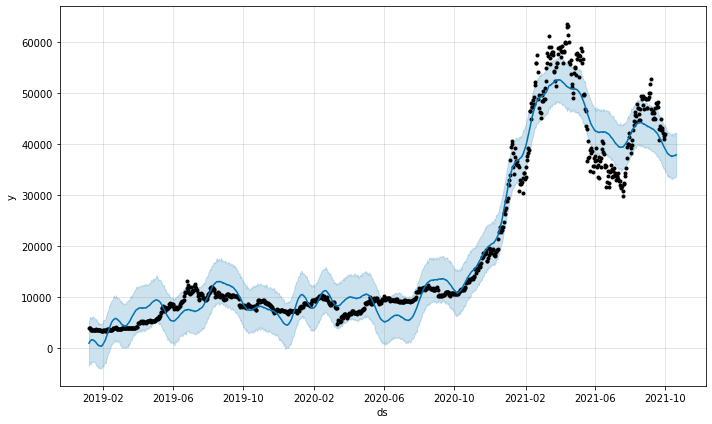

In [368]:
# tmp=df_btc[df_btc.index>='2021-09-01']

model_prophet =create_prophet_model(df_btc)
print(get_prophet_forecast(df_btc,model_prophet,20,True))

# df_hist_new.tail(30)
df_btc.head()


### BLX.TO

In [346]:
# ['PBD', 'VXX', 'b-upper', 'b-lower', 'b-middle', 'rsi', 'macd_hist', 'macd', 'yield3m_shift', 'unemployment_shift']
stock = 'BLX.TO'
features_to_transform = ['open','high','low','close','b-upper','b-lower','b-middle','PBD','VXX'] 
transform = 'log'
n_steps = 25
n_predict = 3
config ={'Economic':
         {'TREASURY_YIELD':[{'interval':'daily','maturity':'3month','name':'yield3m'}],
          'UNEMPLOYMENT':{'interval':'monthly','name':'unemployment'}
          },
         'Technical':{
           'BBANDS':{'interval':'daily','time_period':10},
           'RSI':{'interval':'daily','time_period':7},
           'MACD':{'interval':'daily','time_period':None}
           },
         'Commodities':['VXX','PBD']
         }

# get new data
# df_blx = get_consolidated_stock_data(stock,key,config,'full')
df_new = df_blx.copy()


# # shift features to match the model
df_new = shift_features(df_new,{'yield3m': -60,'unemployment':-60})

# get the trained lstm model
model = keras.models.load_model(f'/content/drive/MyDrive/Colab Notebooks/models/model_{stock}_final')

# get the prophet model
prophet_model = create_prophet_model(df_new)


# Get the features used in the final model
df_features = pd.read_pickle(f'/content/drive/MyDrive/Colab Notebooks/data/{stock}_market_data_features.pickle')
features = [f for f in df_features.columns if f not in ['symbol']]


# initial hist file
start_date = '2021-01-01'
end_date = '2021-09-28'
df_tmp = df_new.loc[df_new.index <=start_date]
df_hist_new =roll_predictions(df_tmp)
df_hist_new.to_pickle(f'/content/drive/MyDrive/Colab Notebooks/data/{stock}_ensemble_hist.pickle')

# backtest for sep 2021
datelist = df_new.loc[end_date:start_date].index
datelist = datelist[::-1]
for dt in datelist:

  df_tmp = df_new.loc[df_new.index <=dt].copy()
  df_orig = df_tmp.copy()

  print(dt," ",df_tmp.index.max())
  print("="*60)

  # transform
  print("=> log transpose\n")
  transform_stationary(df_tmp,features_to_transform,transform)

  #prepare
  print("=>prepare data\n")
  idx_dates, array_y, array_X = prepare_data(df_tmp,n_steps,features)

  # scale the input and outputs
  print("=>scale data\n")
  scaler_X = MinMaxScaler(feature_range=(0,1))
  scaled_X = scaler_X.fit_transform(array_X)
  scaler_y = MinMaxScaler(feature_range=(0,1))
  scaled_y = scaler_y.fit_transform(array_y)


  # make predictions
  print("=>make predictions\n")
  df_pred = make_ensemble_predictions(df_tmp,model,prophet_model,scaler_y,scaled_X,n_steps,len(features),n_predict,df_tmp.index.max(),0.50)

  # get the previous df_hist data
  print("=>get previous file\n")
  df_hist = pd.read_pickle(f'/content/drive/MyDrive/Colab Notebooks/data/{stock}_ensemble_hist.pickle')

  # update the hist file with yesterdays close price, and add the new predictions
  print("=>roll file forward\n")
  df_hist_new =roll_predictions(df_orig,df_pred,df_hist)
  df_hist_new.to_pickle(f'/content/drive/MyDrive/Colab Notebooks/data/{stock}_ensemble_hist.pickle')


# plot
plot_actual_ensemble(stock,df_hist_new)

2021-01-04 00:00:00   2021-01-04 00:00:00
=> log transpose

=>prepare data

=>scale data

=>make predictions

=>get previous file

=>roll file forward

2021-01-05 00:00:00   2021-01-05 00:00:00
=> log transpose

=>prepare data

=>scale data

=>make predictions

=>get previous file

=>roll file forward

2021-01-06 00:00:00   2021-01-06 00:00:00
=> log transpose

=>prepare data

=>scale data

=>make predictions

=>get previous file

=>roll file forward

2021-01-07 00:00:00   2021-01-07 00:00:00
=> log transpose

=>prepare data

=>scale data

=>make predictions

=>get previous file

=>roll file forward

2021-01-08 00:00:00   2021-01-08 00:00:00
=> log transpose

=>prepare data

=>scale data

=>make predictions

=>get previous file

=>roll file forward

2021-01-11 00:00:00   2021-01-11 00:00:00
=> log transpose

=>prepare data

=>scale data

=>make predictions

=>get previous file

=>roll file forward

2021-01-12 00:00:00   2021-01-12 00:00:00
=> log transpose

=>prepare data

=>scale data